In [480]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [481]:
language = 'es'
assert(language in ['en', 'fr', 'es'])

In [482]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [483]:
len(numberbatch.vocab)

651859

In [484]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [485]:
ds_techniques = pd.read_csv('datasets/silknow/es_technique_post2.csv').rename(columns={'technique':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,Brocado de terciopelo rojo. Motivo de gran piñ...,velvet
1,Tapete rectangular formado por tres fragmentos...,satin (fabric)
2,Abanico chino para la exportación. \nLa decor...,embroidery
3,"Fragmento textil, con la ornamentación distrib...",satin (fabric)
4,Fragmento textil con motivos geométricos y veg...,velvet


In [486]:
ds_techniques.label.value_counts()

damask                512
satin (fabric)        228
velvet                111
façonne cut velvet    102
embroidery             66
ciselé velvet          26
plain cut velvet       23
louisine               11
cut velvet              8
muslin                  2
Name: label, dtype: int64

In [487]:
len(ds_techniques)

1089

In [488]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [489]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [490]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [491]:
sorted(ds_techniques.label.unique())

['ciselé velvet',
 'cut velvet',
 'damask',
 'embroidery',
 'façonne cut velvet',
 'louisine',
 'muslin',
 'plain cut velvet',
 'satin (fabric)',
 'velvet']

In [492]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'rosal', 'rosáceo', 'rosa', 'rosado', 'rosaleda', 'rosalista', 'pimpollo'])

In [493]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { 
            'damask':'damasco',
            'embroidery':'bordado',
            'velvet':'terciopelo',
            'satin (fabric)':'raso',
            'muslin':'tafetán',
            'louisine':'tafetán',
            'plain cut velvet':'terciopelo',
             'façonne cut velvet':'terciopelo',
            'cut velvet':'terciopelo',
             'ciselé velvet':'terciopelo'}

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

5
['bordado', 'damasco', 'raso', 'tafetán', 'terciopelo']


In [494]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 81.6 ms, sys: 7.55 ms, total: 89.2 ms
Wall time: 84.1 ms


In [495]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'bordado': 79, 'damasco': 811, 'raso': 422, 'tafetán': 6, 'terciopelo': 63}

In [496]:
labels_cgr.keys()

dict_keys(['bordado', 'damasco', 'raso', 'tafetán', 'terciopelo'])

In [497]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [498]:
ds_techniques.text[0]

'Brocado de terciopelo rojo. Motivo de gran piña central con ancha orla, rodeada de clavellinas y capullos en perfiles de terciopelo. Conserva poco hilo de oro y nada de anillado. Rematado con estrecho galón rojo y oro de la epoca.'

In [499]:
data_silknow = ds_techniques.text.tolist()

In [500]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [501]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 145 ms, sys: 1.33 s, total: 1.47 s
Wall time: 1.8 s


In [502]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [503]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [504]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 42.4 ms, sys: 1.27 s, total: 1.31 s
Wall time: 1.28 s


In [505]:


predictions[:10]

[4, 1, 0, 2, 2, 3, 0, 0, 0, 0]

In [506]:

prediction_labels = [labels[p] for p in predictions]

In [507]:
set(prediction_labels)

{'bordado', 'damasco', 'raso', 'tafetán', 'terciopelo'}

In [508]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Techniques

In [509]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('techniques-es-predictions.csv')

              precision    recall  f1-score   support

     bordado      0.894     0.060     0.112       987
     damasco      0.068     0.636     0.123        55
        raso      0.035     0.615     0.066        13
     tafetán      0.000     0.000     0.000         6
  terciopelo      0.104     1.000     0.188        28

    accuracy                          0.119      1089
   macro avg      0.220     0.462     0.098      1089
weighted avg      0.817     0.119     0.113      1089



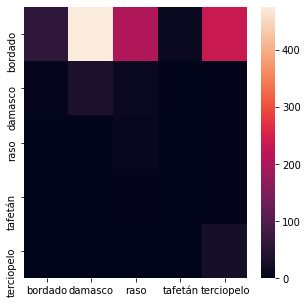

In [510]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [511]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     bordado      0.394     0.788     0.525        33
     damasco      0.072     0.685     0.131        54
        raso      0.053     0.923     0.100        13
     tafetán      1.000     0.867     0.929        15
  terciopelo      0.993     0.275     0.431       974

    accuracy                          0.327      1089
   macro avg      0.502     0.708     0.423      1089
weighted avg      0.918     0.327     0.422      1089



In [512]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

     bordado      0.394     0.812     0.531        32
     damasco      0.072     0.685     0.131        54
        raso      0.925     0.995     0.959       212
     tafetán      1.000     1.000     1.000        13
  terciopelo      1.000     0.347     0.515       778

    accuracy                          0.511      1089
   macro avg      0.678     0.768     0.627      1089
weighted avg      0.922     0.511     0.589      1089

